In [1]:
%matplotlib inline
#%matplotlib widget

In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

import re # For regular expressions

#import sklearn as sk
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, max_error, accuracy_score
from sklearn.decomposition import TruncatedSVD

from scipy.interpolate import RBFInterpolator

In [3]:
path = '../Experimental data/Heat conduction processed/'
files = []
experiments = {}
for dirname, _, filenames in os.walk(path):
    for filename in filenames:
        if re.search("csv$", filename):  # Search if filename ends in 'csv'
            experiments.update({filename.split('.')[0]:(os.path.join(dirname,filename))})


In [4]:
### Remove any unwanted files - eg .ipynb_checkpoints

experiments_dummy = experiments.copy() # Create dummy variable so dict does not change while iterating
for k,v in experiments.items():
    if re.search("ipynb_checkpoints", v):
        del(experiments_dummy[k])
experiments = experiments_dummy

In [5]:
#experiments

In [30]:
class Experiment:
    """
    Create an instance of the class "Experiment".
    """
    def __init__(self, file,*,timestep=5):
        """
        Docstring:
        Takes the path of the input file is csv format,
        stores it in a dataframe with columns for each timestep
        and rows for each pixel.
        
        Parameters:
        ----------
        timestep: the time interval between each data snapshot
        
        Returns
        -------
        Plots a subset of the input data
        """
        self.file = file
        self.timestep = timestep
        self.data = pd.read_csv(self.file)
        self.data.columns.name = 'time [$s$]'
        self.data.columns = self.data.columns.astype(int)*timestep
        self.data.index.name = 'pixel'
        self.data.loc[:,::100].plot(title=f"Plot of {self.file.split('/')[-1]}'s data at {100*timestep}s intervals", grid=True, ylabel='Temperature [$\degree C$]')
    
    def data(self):
        return(self.data)
    
    def set_meta_params(self, **kwargs):
        """
        Docstring:
        Set parameters to reduce the amound of data in the dataframe. Note that all arguments should be passed at once, else the default values will be used
        
        Parameters:
        ----------
        start_pix: starting pixel. defualt=70
        end_pix: ending pixel. defualt=500
        pix_spacing: spacing between pixels. defualt=50
        start_t: first timestep to include in dataset. defualt=0
        end_t: last timestep to include in dataset. defualt=2200
        t_interval: spacing between desired samples of time defualt = 500s
        
        Returns
        -------
        dict of paramaters to be used to reduce data
        Plots a graph of data to show where reductions will be made
        """
            
        start_pix = kwargs.get("start_pix", 70)
        end_pix = kwargs.get("end_pix", 500)
        pix_spacing = kwargs.get("pix_spacing", 50)
        start_t= kwargs.get("start_t", 0)
        end_t= kwargs.get("end_t", 2200)
        t_interval= kwargs.get("t_interval", 500)
        
        self.meta = {
            "start_pix": start_pix,
            "end_pix": end_pix,
            "pix_spacing": pix_spacing,
            "start_t": start_t,
            "end_t": end_t,
            "t_interval": t_interval,
            }
        
        data = self.data.loc[:,::int(t_interval/self.timestep)]
        plt.plot(data)
        plt.title(f"Plot of {self.file.split('/')[-1]}'s data at {t_interval}s intervals")
        plt.grid()
        plt.ylabel("Temperature [$\degree C$]")
        plt.xlabel("pixel")
        plt.axvline(start_pix, c='k', linestyle='--')
        plt.axvline(end_pix, c='k', linestyle='--')
        
        return(self.meta)
    
    
    def reduce_data(self, **kwargs):
        """
        Docstring:
        Reduce a full dataframe with time as columns and pixels as rows to a smaller dataframe.
        
        Parameters:
        ----------
        """
        _meta = self.meta.copy()
        print(f"Using meta parameters {_meta}")
        self.reduced_data = self.data.loc[_meta["start_pix"]:_meta["end_pix"]:_meta["pix_spacing"], _meta["start_t"]:_meta["end_t"]:int(_meta["t_interval"]/self.timestep)]
        return(self.reduced_data)

    def temp_profile(self):
        """
        Docstring:
        Plot reduced temperature profile of reduced dataframe at discrete times
        Overrides pix_spacing to 1
        """
        _meta = self.meta.copy()
        _meta.update({"pix_spacing":1})
        print(f"Using meta parameters of {_meta}")
        self.data.loc[_meta["start_pix"]:_meta["end_pix"]:_meta["pix_spacing"], _meta["start_t"]:_meta["end_t"]:int(_meta["t_interval"]/self.timestep)].plot(title="Temperature profile", ylabel='Temperature [$\degree C$]', grid=True)
        #self.reduced_data.plot(title="Temperature profile", ylabel='Temperature [$\degree C$]', grid=True)
        
    def temp_gradient(self):
        dtdx = np.gradient(self.data.to_numpy(), axis=0)
        dTdt = np.gradient(self.data.to_numpy(), axis=1)
        return dtdx, dTdt
        #dTdx = pd.DataFrame(np.gradient(X, axis=1).T)
    
    def point_over_time(self):
        """
        Docstring:
        Plots pixels from reduced dataset, over time, but overrides the t_interval to 1s
        """
        _meta = self.meta.copy()
        _meta.update({"t_interval":1})
        print(f"Using meta parameters of {_meta}")
        _reduced = self.data.loc[_meta["start_pix"]:_meta["end_pix"]:_meta["pix_spacing"], _meta["start_t"]:_meta["end_t"]:int(1)].transpose()
        _reduced.plot(title="Temp of pixel over time", ylabel='Temperature [$\degree C$]', grid=True)
        #return(self.reduced_data.transpose())
        
    def plot_pcolor(self):
        fig, (ax1) = plt.subplots(1,1) #, figsize=(35,10))
        ax1.set_title('Original')
        ax1.pcolor(self.data)
        ax1.set_ylabel('pixel #')
        ax1.set_xlabel('snapshot #')
        #fig.colorbar(self.data)
        
    def SVD(self, *n_singular_values):
        if not n_singular_values:
            n_singular_values = (1,2,5,10,50,100) # Default singular values if none are given
        X = self.data.to_numpy()
        U, S, VT = np.linalg.svd(X,full_matrices=False)
        S = np.diag(S)
        j = 0
        for r in n_singular_values:
            # Construct approximate image
            Xapprox = U[:,:r] @ S[0:r,:r] @ VT[:r,:]
            err = Xapprox - X
            fig, (ax1, ax2) = plt.subplots(1,2, figsize=(35,10))
            plt.figure(j+1)
            j += 1
            ax1.pcolor(Xapprox.T)
            ax1.set_title('Recovered temperature using SVD')
            ax2.pcolor(err.T)
            ax2.set_title('Error between original readings and recovered SVD values')
            plt.axis('on')
            plt.xlabel('Time [$s$]')
            plt.ylabel('Pixel')
            #fig.colorbar(mappable=[0,120], ax=ax2)
            #plt.colorbar(label='Temperature [$ \degree C$]')
            fig.suptitle(f'SVD with {r} singular values', fontsize=16)
            fig.show()
        if np.shape(X)[0] > np.shape(X)[1]:
            print("Economy SVD")
            r = np.shape(X)[0]
            Xapprox = U[:,:r] @ S[0:r,:r] @ VT[:r,:]
            err = Xapprox - X
            fig, (ax1, ax2) = plt.subplots(1,2, figsize=(35,10))
            plt.figure(j+1)
            j+=1
            ax1.pcolor(Xapprox.T)
            ax1.set_title('Recovered temperature using SVD')
            ax2.pcolor(err.T)
            ax2.set_title('Error between original readings and recovered SVD values')
            plt.axis('on')
            plt.xlabel('Time [$s$]')
            plt.ylabel('Pixel')
            fig.suptitle(f'SVD with {r} singular values', fontsize=16)
            fig.show()
        plt.figure(j+1)
        plt.semilogy(np.diag(S))
        for i in n_singular_values:
            plt.scatter(i, np.diag(S)[i], c='r')
            plt.text(i+0.5, np.diag(S)[i], f"{i}")
        plt.title('Singular Values')
        plt.show()
        j+=1
        
        plt.figure(j+1)
        plt.plot(np.cumsum(np.diag(S))/np.sum(np.diag(S)))
        for i in n_singular_values:
            plt.scatter(i, np.cumsum(np.diag(S))[i]/np.diag(S).sum(), c='r')
            plt.text(i+0.5, np.cumsum(np.diag(S))[i]/np.diag(S).sum(), f"{i}")
        plt.title('Singular Values: Cumulative Sum')
        plt.show()
        
    def PCA(self, *n_singular_values):
        scaler = StandardScaler()
        if not n_singular_values:
            n_singular_values = (1,2,5,10,50,100) # Default singular values if none are given
        _X = self.data.to_numpy()
        X = scaler.fit_transform(_X)
        return(X)

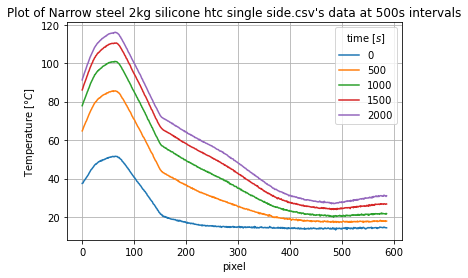

In [31]:
steel_ss_sil = Experiment('../Experimental data/Heat conduction processed/Narrow steel 2kg silicone htc single side.csv')
#steel_ss_dry = Experiment('../Experimental data/Heat conduction processed/Narrow steel 2kg dry single side.csv')

In [8]:
steel_ss_sil.data

time [$s$]  0     5     10    15    20    25    30    35    40    45    ...  \
pixel                                                                   ...   
0           37.5  38.5  38.9  39.6  40.1  40.5  41.1  41.5  42.1  42.5  ...   
1           37.6  38.8  39.3  39.9  40.4  40.8  41.4  41.9  42.5  42.8  ...   
2           37.9  39.4  39.8  40.3  40.7  41.1  41.9  42.4  42.7  43.1  ...   
3           38.7  39.6  40.1  40.9  41.3  41.7  42.5  43.0  43.3  43.7  ...   
4           38.9  40.1  40.6  41.3  41.7  42.1  42.9  43.3  43.8  44.3  ...   
...          ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  ...   
582         14.6  15.3  15.2  15.4  15.3  15.4  15.5  15.5  15.8  15.6  ...   
583         14.5  15.3  15.2  15.4  15.4  15.5  15.7  15.7  15.5  15.1  ...   
584         14.5  15.2  15.2  15.5  15.2  15.3  15.7  15.7  15.5  15.3  ...   
585         14.4  15.0  14.8  15.1  15.1  15.1  15.6  15.6  15.4  15.3  ...   
586         14.4  15.2  15.2  15.6  15.6  15.4  15.4  15.3  15.5  15.3  ...   

time [$s$]  2365  2370  2375  2380  2385  2390  2395  2400  2405  2410  
pixel                                                                   
0           94.3  94.3  94.4  94.4  94.6  94.6  94.5  94.6  94.8  94.8  
1           95.3  95.3  95.4  95.5  95.6  95.6  95.6  95.6  95.9  95.9  
2           96.0  96.0  96.0  96.0  96.3  96.3  96.2  96.3  96.5  96.5  
3           96.9  97.0  97.0  97.1  97.2  97.3  97.3  97.3  97.5  97.5  
4           97.8  97.8  97.9  98.0  98.1  98.1  98.1  98.2  98.4  98.4  
...          ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  
582         33.4  33.3  33.4  33.4  33.5  33.6  33.7  33.7  33.9  33.9  
583         33.2  33.2  33.3  33.3  33.4  33.5  33.5  33.6  33.7  33.7  
584         33.4  33.4  33.4  33.5  33.5  33.5  33.7  33.8  33.8  33.8  
585         33.4  33.3  33.3  33.4  33.5  33.5  33.7  33.6  33.7  33.9  
586         33.4  33.3  33.4  33.5  33.5  33.6  33.7  33.7  33.8  33.9  

[587 rows x 483 columns]

{'start_pix': 75,
 'end_pix': 490,
 'pix_spacing': 50,
 'start_t': 0,
 'end_t': 2200,
 't_interval': 500}

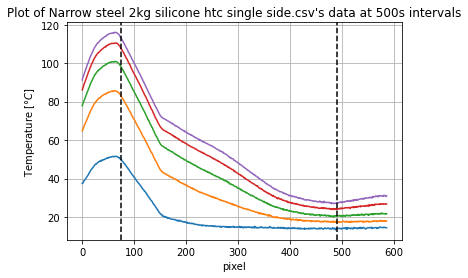

In [9]:
steel_ss_sil.set_meta_params(start_pix=75, end_pix=490, pix_spacing=50)

In [10]:
reduced_data = steel_ss_sil.reduce_data()

Using meta parameters {'start_pix': 75, 'end_pix': 490, 'pix_spacing': 50, 'start_t': 0, 'end_t': 2200, 't_interval': 500}


In [11]:
reduced_data

time [$s$]  0     500   1000   1500   2000
pixel                                     
75          49.9  82.7  98.0  107.6  112.9
125         31.5  57.9  71.8   80.8   86.5
175         18.9  40.3  53.6   62.3   68.4
225         15.8  33.0  45.6   54.3   60.0
275         14.8  28.2  38.9   47.1   52.9
325         14.6  23.4  31.1   38.0   43.1
375         14.4  20.1  25.0   29.7   34.1
425         14.0  18.3  22.1   26.2   29.5
475         14.1  17.6  20.9   24.4   27.5

Using meta parameters of {'start_pix': 75, 'end_pix': 490, 'pix_spacing': 1, 'start_t': 0, 'end_t': 2200, 't_interval': 500}


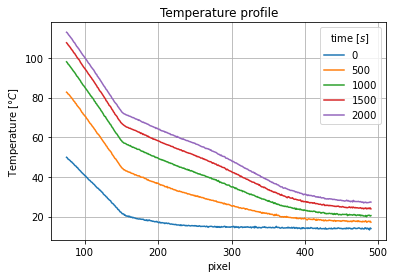

In [12]:
steel_ss_sil.temp_profile()

Using meta parameters of {'start_pix': 75, 'end_pix': 490, 'pix_spacing': 50, 'start_t': 0, 'end_t': 2200, 't_interval': 1}


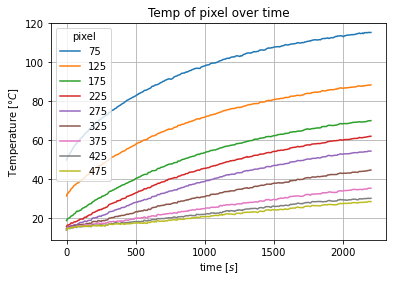

In [13]:
steel_ss_sil.point_over_time()

In [14]:
steel_ss_sil.temp_gradient()

(array([[ 0.1 ,  0.3 ,  0.4 , ...,  1.  ,  1.1 ,  1.1 ],
        [ 0.2 ,  0.45,  0.45, ...,  0.85,  0.85,  0.85],
        [ 0.55,  0.4 ,  0.4 , ...,  0.85,  0.8 ,  0.8 ],
        ...,
        [-0.05, -0.15, -0.2 , ...,  0.  ,  0.  ,  0.1 ],
        [-0.05,  0.  ,  0.  , ..., -0.05,  0.  ,  0.05],
        [ 0.  ,  0.2 ,  0.4 , ...,  0.1 ,  0.1 ,  0.  ]]),
 array([[1.  , 0.7 , 0.55, ..., 0.15, 0.1 , 0.  ],
        [1.2 , 0.85, 0.55, ..., 0.15, 0.15, 0.  ],
        [1.5 , 0.95, 0.45, ..., 0.15, 0.1 , 0.  ],
        ...,
        [0.7 , 0.35, 0.15, ..., 0.05, 0.  , 0.  ],
        [0.6 , 0.2 , 0.05, ..., 0.  , 0.15, 0.2 ],
        [0.8 , 0.4 , 0.2 , ..., 0.05, 0.1 , 0.1 ]]))

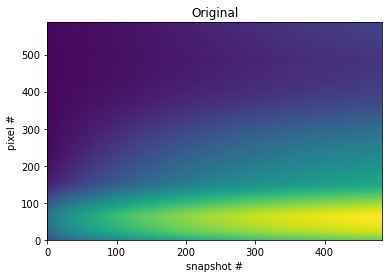

In [15]:
steel_ss_sil.plot_pcolor()

Economy SVD


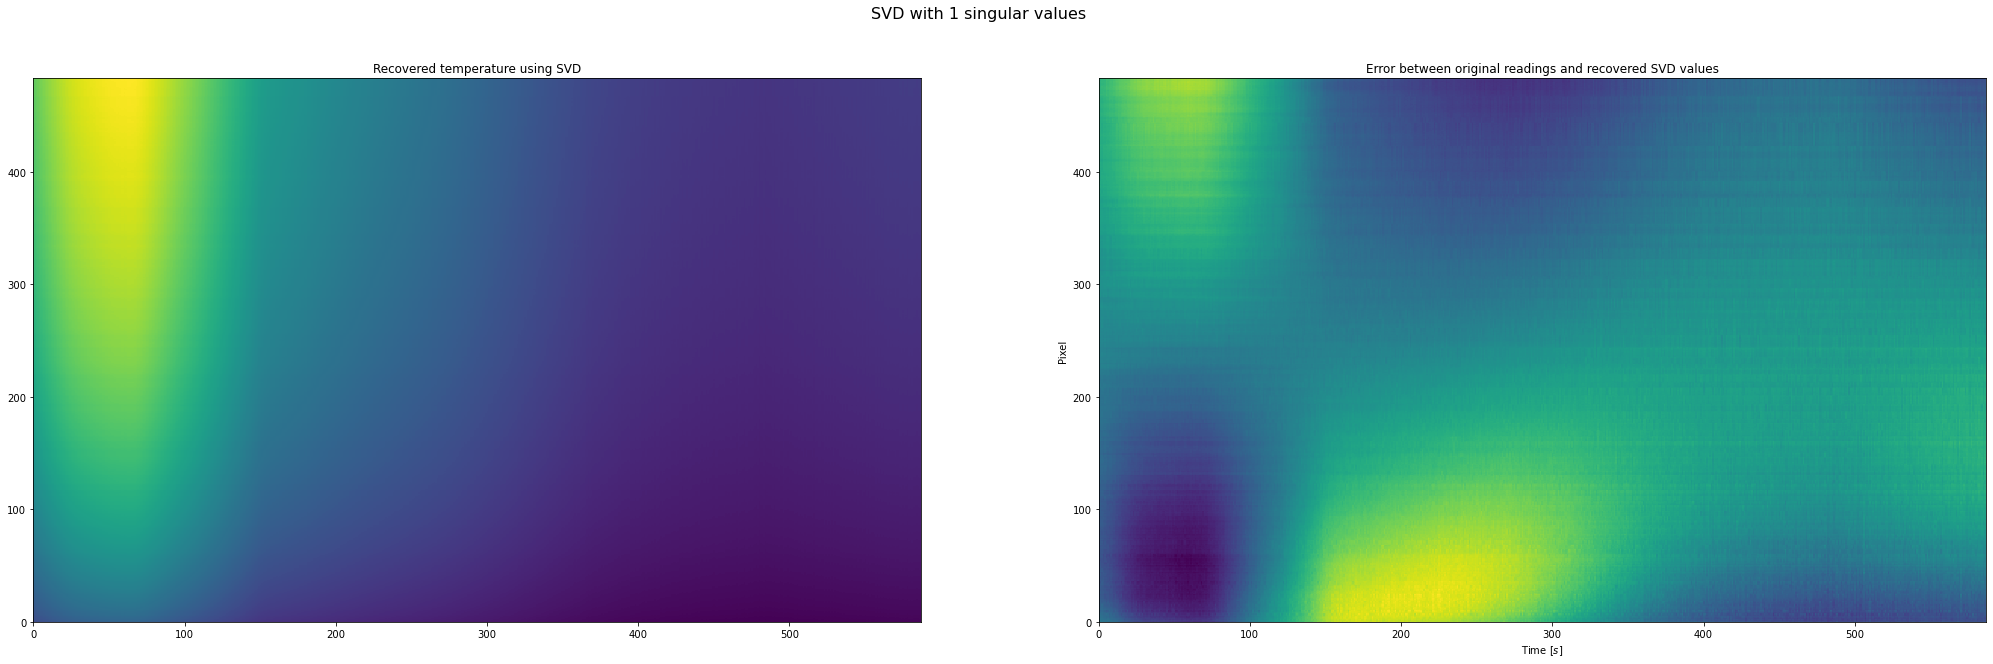

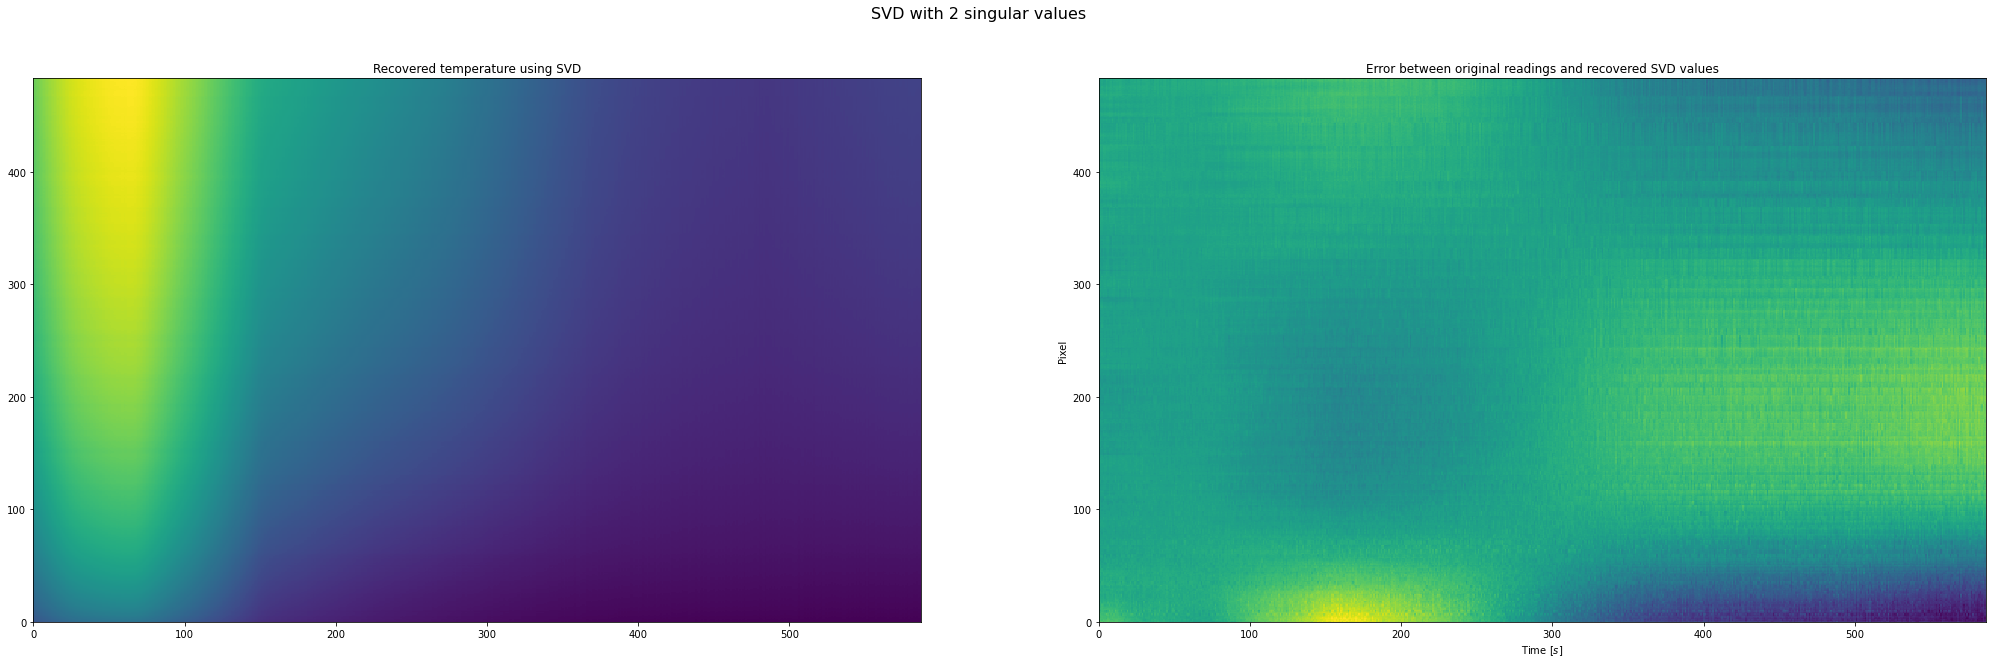

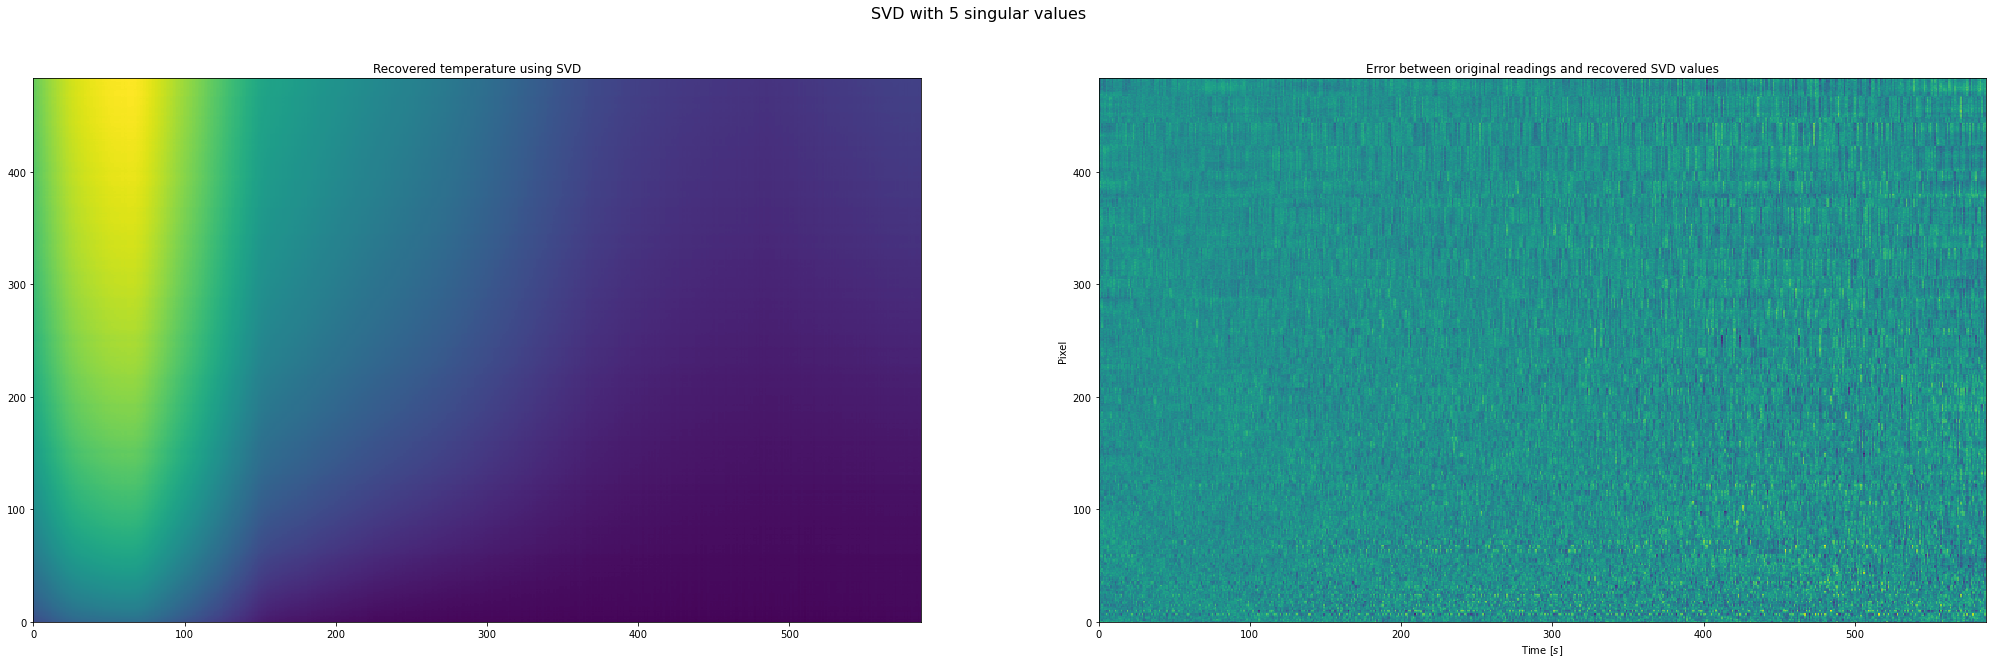

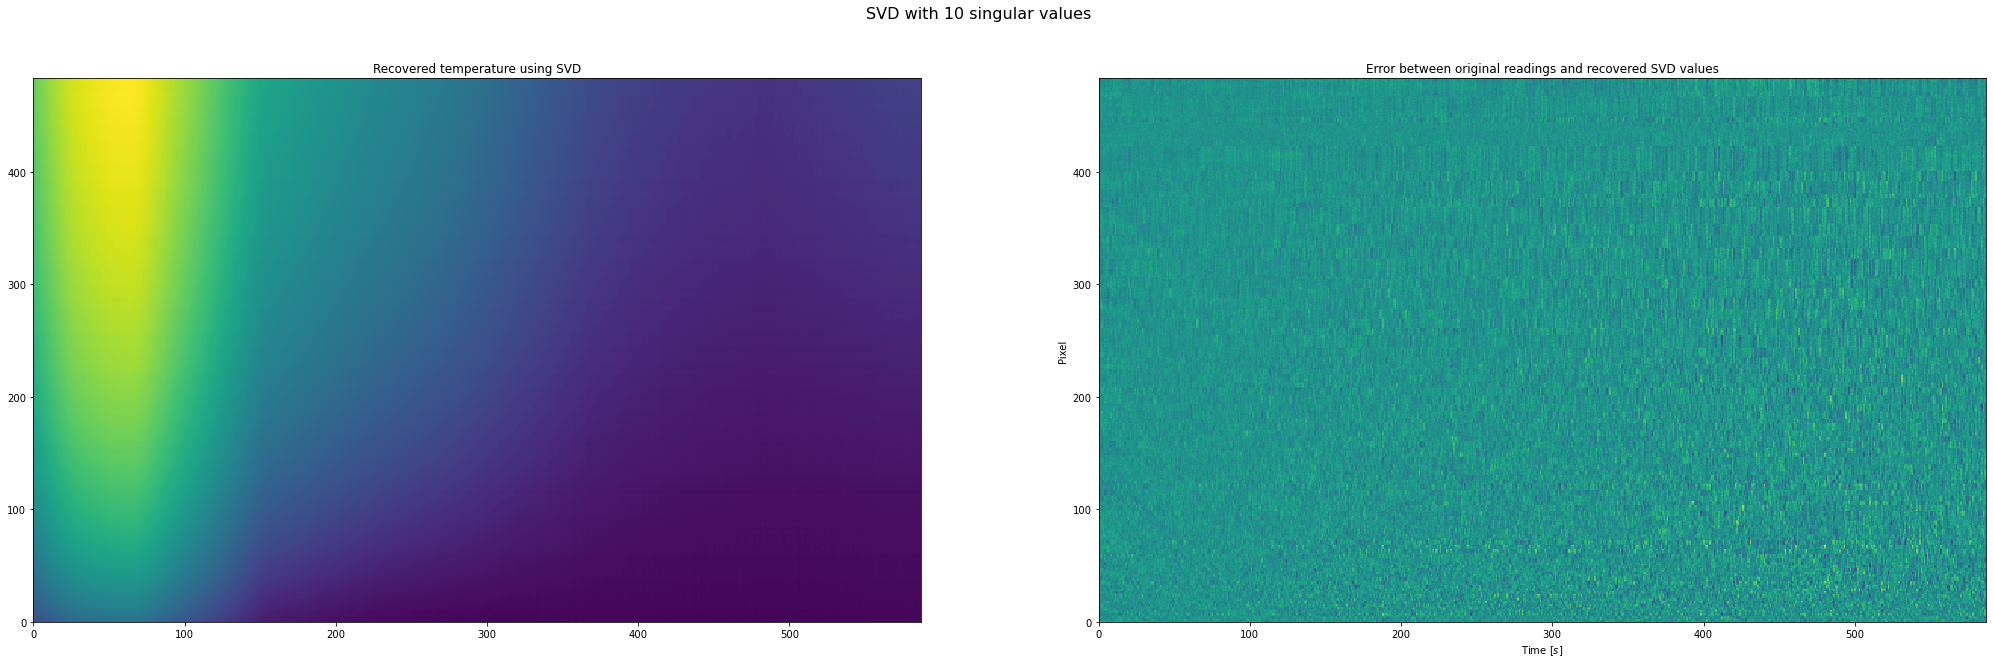

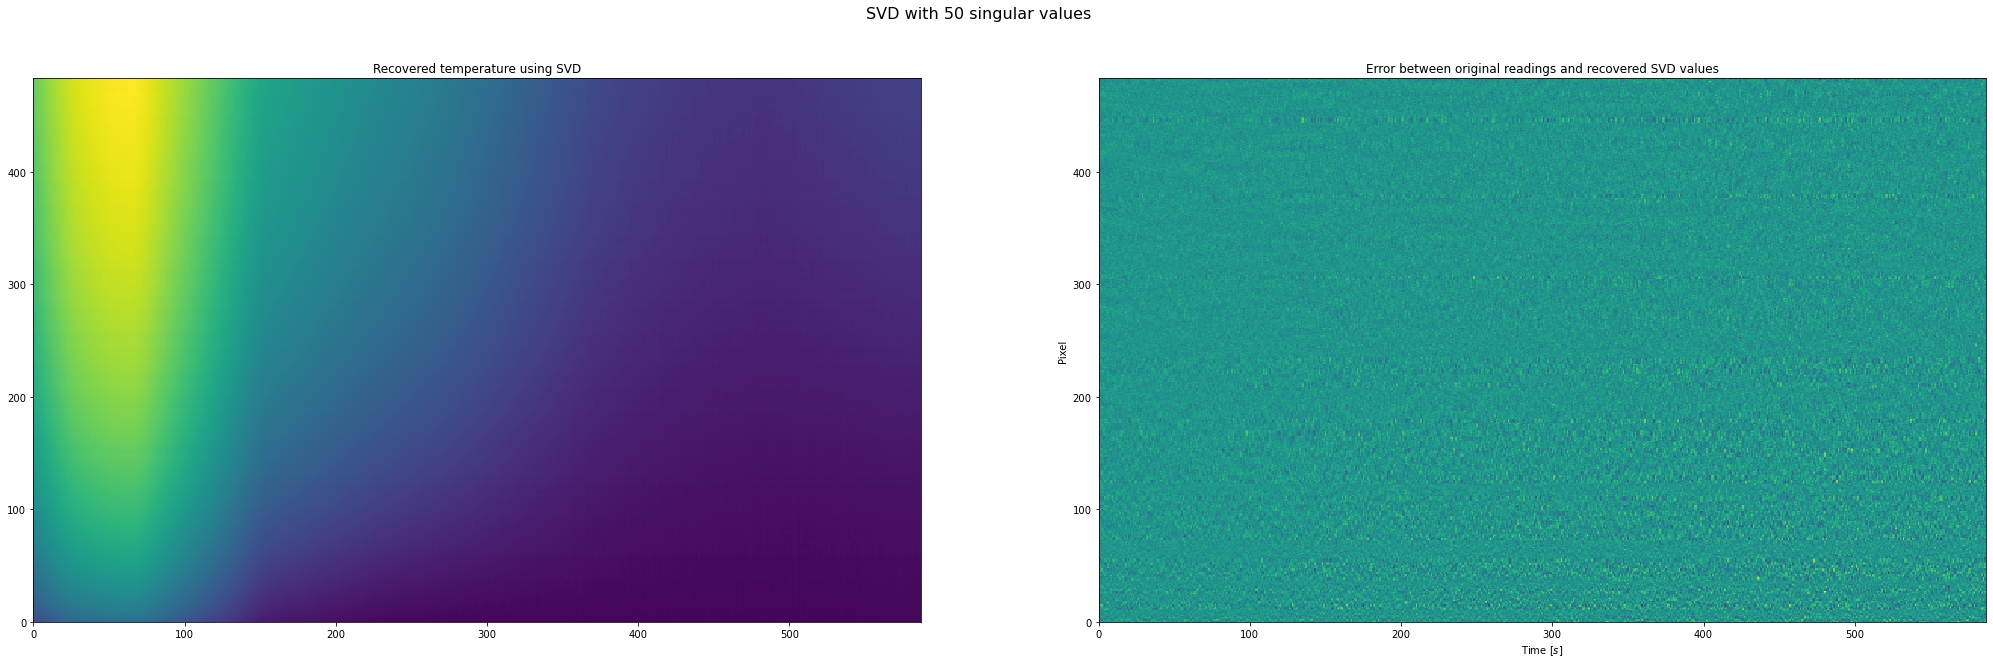

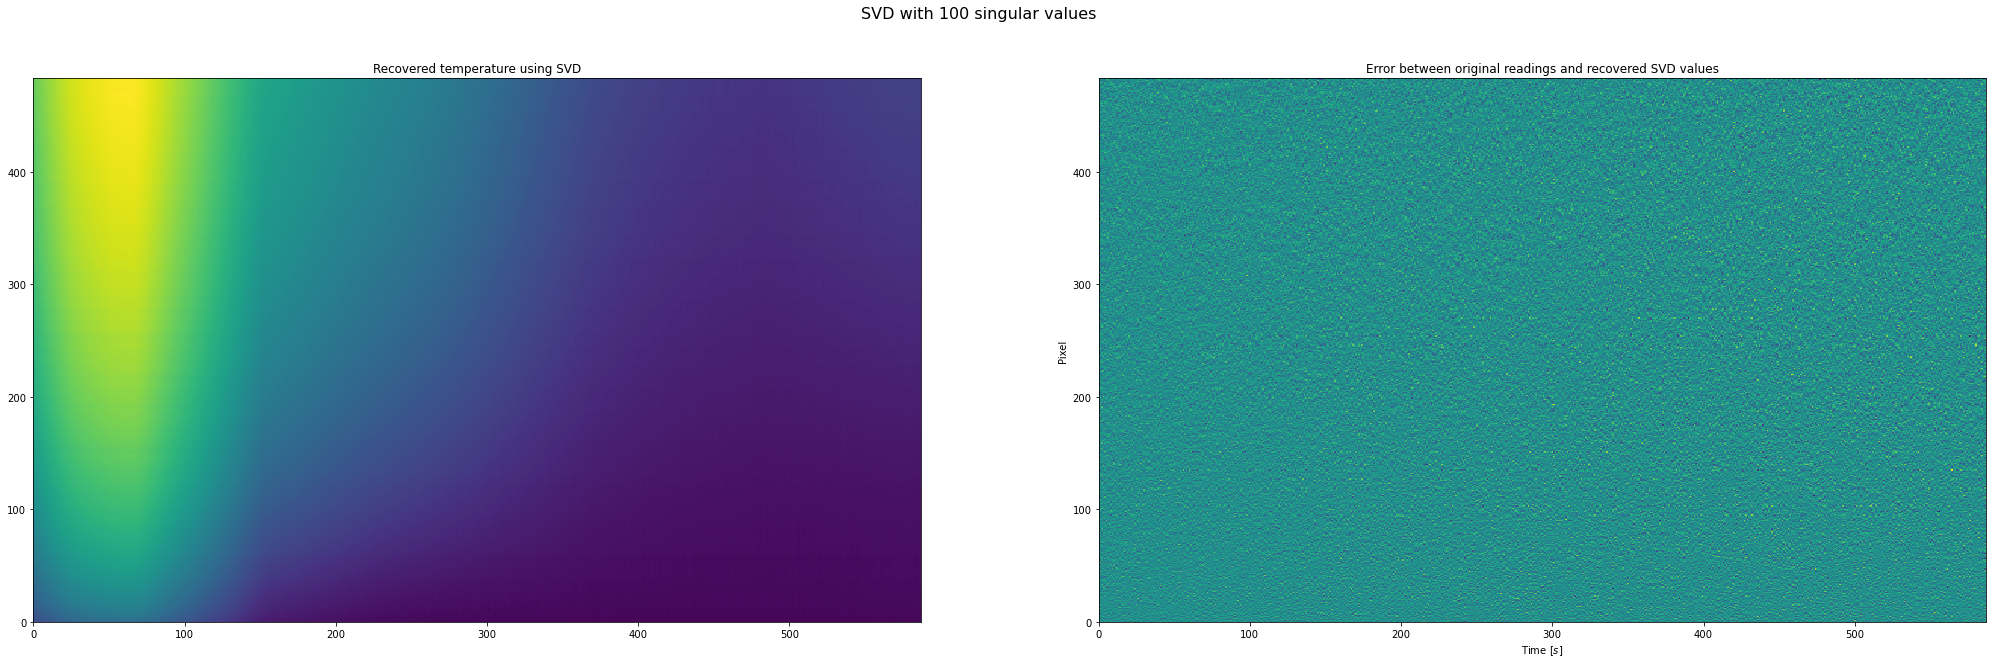

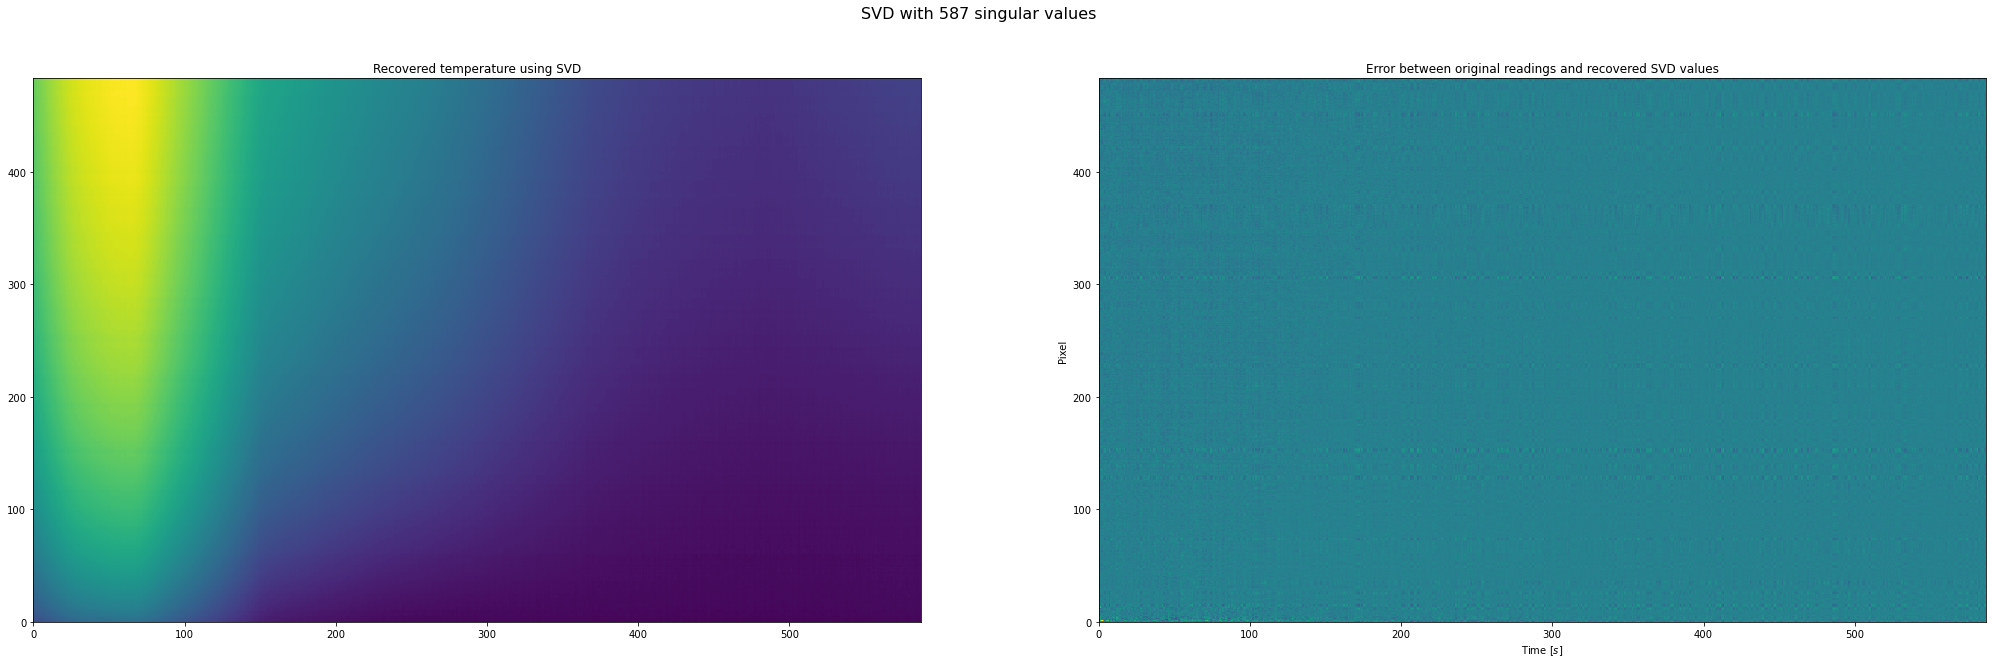

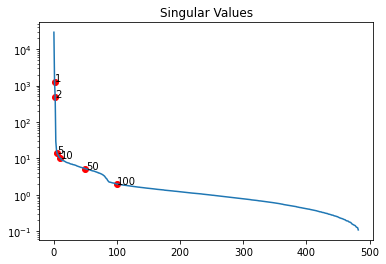

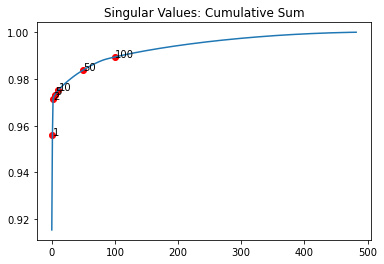

In [16]:
steel_ss_sil.SVD()

In [32]:
PCA = steel_ss_sil.PCA()

In [33]:
PCA

array([[ 1.2395157 ,  1.23564539,  1.23818237, ...,  1.15216565,
         1.15321429,  1.15160785],
       [ 1.24749066,  1.2592094 ,  1.26905017, ...,  1.18563977,
         1.18993593,  1.18836789],
       [ 1.27141555,  1.30633743,  1.30763491, ...,  1.20907166,
         1.20996592,  1.20841883],
       ...,
       [-0.59472571, -0.59449285, -0.59073436, ..., -0.88306107,
        -0.88316775, -0.88690365],
       [-0.60270067, -0.61020219, -0.62160215, ..., -0.88975589,
        -0.88650608, -0.88356183],
       [-0.60270067, -0.59449285, -0.59073436, ..., -0.88640848,
        -0.88316775, -0.88356183]])

In [35]:
X = steel_ss_sil.data

In [29]:
dTdx = pd.DataFrame(np.gradient(X, axis=1).T)
d2Tdx2 = pd.DataFrame(np.gradient(np.gradient(X, axis=1), axis=1).T)

NameError: name 'X' is not defined

<AxesSubplot:>

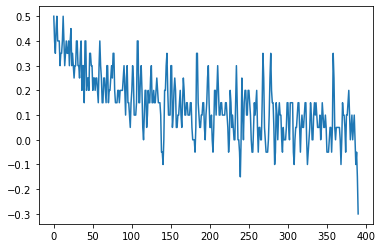

In [23]:
dTdx[0].plot()

<AxesSubplot:>

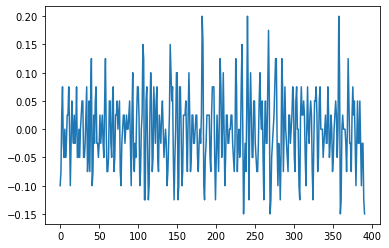

In [24]:
d2Tdx2[0].plot()

In [25]:
dTdx

0     1     2     3     4     5     6     7
0    0.50  0.30  0.80  0.20  0.80  0.30  0.20  0.90
1    0.40  0.25  0.45  0.10  0.45  0.15  0.15  0.45
2    0.35  0.30  0.15  0.00  0.10  0.00  0.05  0.05
3    0.45  0.45  0.10  0.05  0.25  0.00  0.10  0.00
4    0.50  0.40  0.10  0.20  0.30  0.10  0.20  0.00
..    ...   ...   ...   ...   ...   ...   ...   ...
386  0.00  0.00  0.05  0.00  0.00  0.00  0.00  0.00
387 -0.10 -0.10  0.00 -0.05 -0.05 -0.05 -0.05 -0.05
388 -0.05 -0.05 -0.05 -0.05 -0.10  0.00  0.00 -0.05
389 -0.15 -0.05 -0.05  0.00  0.05  0.00 -0.05  0.00
390 -0.30 -0.10  0.00  0.00  0.20  0.00 -0.10  0.00

[391 rows x 8 columns]

In [26]:
# pixels = np.arange(70,500,50)

# def pix_over_time(pixels):
#     for pix in pixels:
#         plt.plot(df.loc[pix], label=pix)
#     plt.xlabel('Time [$s$]')
#     plt.ylabel('Temperature [$\degree C$]')
#     plt.legend(title='Pixel #')
#     plt.grid()
#     plt.show()
# pix_over_time(pixels)    

In [28]:
# X = df.to_numpy()
# plt.figure(figsize=(30,20))
# for pix in pixels:
#     plt.grid(True)
#     time = range(0, X.shape[1]*5, 5)
#     dTdt = np.gradient(X[pix])
#     # plt.figure(figsize=(30,15))
#     plt.plot(time, dTdt,label=pix)
#     plt.title('Instantaneous rate of temperature change at a given pixel')
#     plt.xlabel('Time [$s$]')
#     plt.ylabel('Temperature gradient $\\frac{dT}{dt}$ [$ \\frac{\degree C}{s}$]')
#     plt.legend(title='Pixel #')
#     #plt.show()
# plt.show()    

In [29]:
#plt.plot(df.loc[200])

In [30]:
# #X_train, X_test = train_test_split(X.T, shuffle=False, random_state=42)
# #X_train, X_test = X_train.T, X_test.T
# p = np.arange(0,X.shape[0]).T
# t = np.arange(0, X.shape[1])*5
# XX = np.meshgrid(t,p)
# t_s = XX[0].shape

In [31]:
# def grad_pix_over_time(pixels):
#     for pix in pixels:
#         t_prev = df.loc[pix][0:200].diff(periods=-5)
#         t_next = df.loc[pix][0:200].diff(periods=5)
#         plt.plot((t_next - t_prev)/2, label=pix)
#     plt.xlabel('Time [$s$]')
#     plt.ylabel('Gradient [$ \\frac{\degree C}{s}$]')
#     plt.legend(title='Pixel #')
#     plt.show()
# grad_pix_over_time(pixels)

NameError: name 'pixels' is not defined

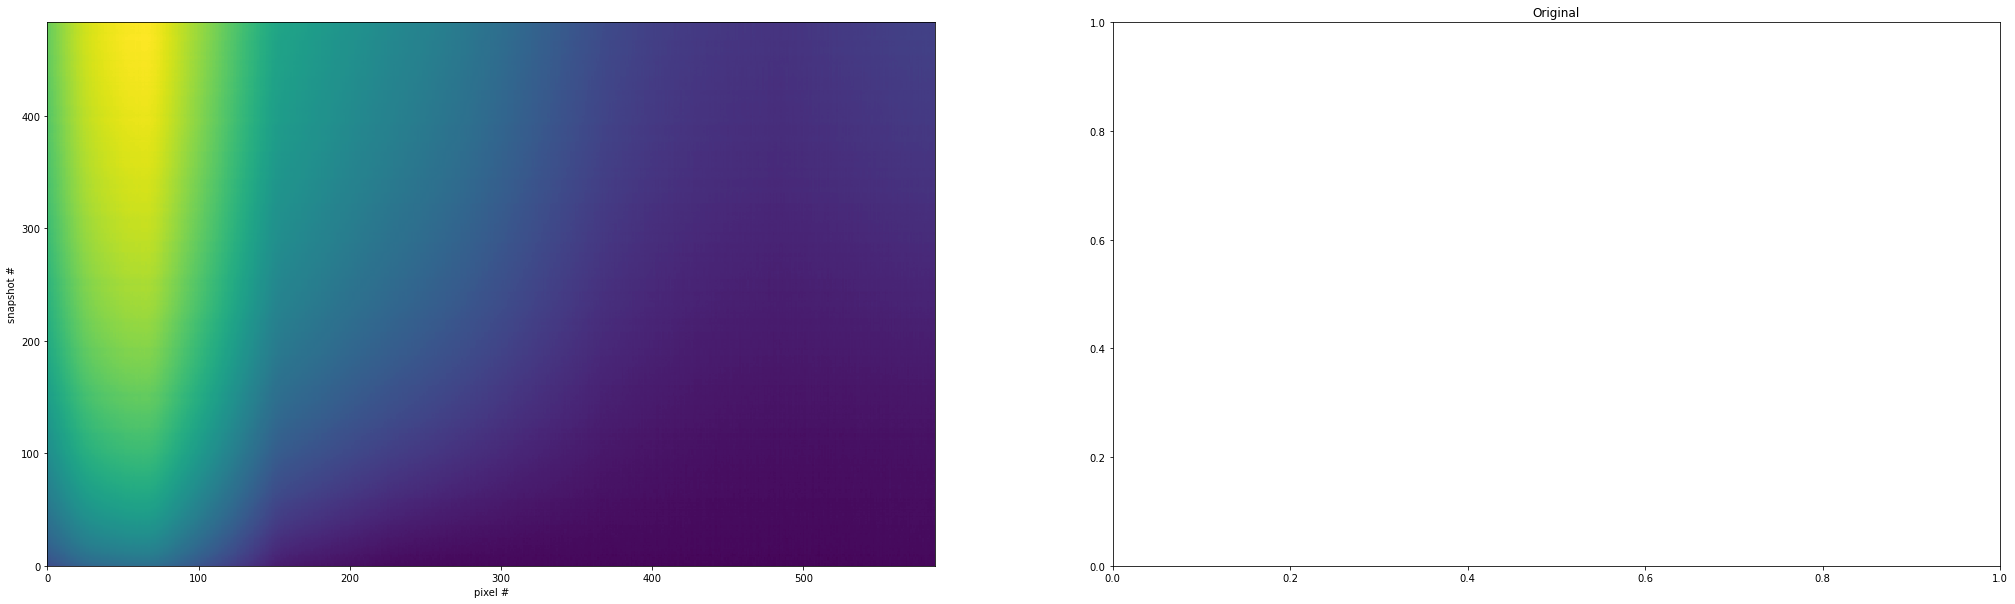

In [32]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(35,10))
plt.title('Original')
ax1.pcolor(X.T)
ax1.set_xlabel('pixel #')
ax1.set_ylabel('snapshot #')
#x1.
for pix in pixels:
    ax2.plot(X[pix,:].T, label=pix)
ax2.set_ylabel('temperature')
ax2.set_xlabel('snapshot #')
#plt.axis('off')
#plt.colorbar(label='Temperature [$ \degree C$]')
plt.legend(title='pixel')
fig.suptitle('Original data', fontsize=16)
fig.show()

U, S, VT = np.linalg.svd(X,full_matrices=False)
S = np.diag(S)

j = 0
for r in (1, 2, 5, 20, 100):
    # Construct approximate image
    Xapprox = U[:,:r] @ S[0:r,:r] @ VT[:r,:]
    err = Xapprox - X
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize=(35,20))
    #plt.figure(j+1)
    #j += 1
    ax1.pcolor(Xapprox.T)
    ax1.set_title('Recovered temperature using SVD')
    ax2.pcolor(err.T)
    ax2.set_title('Error between original readings and recovered SVD values')
    for pix in pixels:
        ax3.plot(Xapprox[pix,:].T)
        ax4.plot(Xapprox[pix,:].T - X[pix,:].T)
    ax3.set_ylabel('temperature')
    ax3.set_xlabel('snapshot #')
    ax4.set_ylabel('temperature')
    ax4.set_xlabel('snapshot #')
    #plt.axis('on')
    #plt.xlabel('Time [$s$]')
    #plt.ylabel('Pixel')|
    #fig.colorbar(mappable=[0,120], ax=ax2)
    #plt.colorbar(label='Temperature [$ \degree C$]')
    #help(fig)
    fig.suptitle(f'SVD with {r} singular values', fontsize=16)
    fig.show()
    #print(f'r = {r} and U = {VT[:r,:]}')

In [36]:
z = np.zeros_like(X, dtype=tuple)
row,col = X.shape
for pix in range(row):
    for time in range(col):
        z[pix,time] = XX[1][pix,time], XX[0][pix,time]

NameError: name 'XX' is not defined

In [ ]:
z = np.stack(XX, axis=-1) # [coord, time, pixel] # Alternative method that sets input as 3D array rather than 2D array with entries as tuples

In [ ]:
z = XX[0]

In [ ]:
z

In [ ]:
reg = LinearRegression()
reg.fit(z, X)

In [28]:
reg.coef_

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [29]:
reg = sk.linear_model.Ridge(alpha=.5)
reg.fit(z,X)

Ridge(alpha=0.5)

In [30]:
reg.coef_

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [31]:
SVD = TruncatedSVD(n_components=5,
    algorithm='randomized',
    n_iter=5,
    random_state=42, # Choose a state for repeatable results
    )
model = SVD.fit(df)

In [32]:
XX

[array([[   0,    5,   10, ..., 2425, 2430, 2435],
        [   0,    5,   10, ..., 2425, 2430, 2435],
        [   0,    5,   10, ..., 2425, 2430, 2435],
        ...,
        [   0,    5,   10, ..., 2425, 2430, 2435],
        [   0,    5,   10, ..., 2425, 2430, 2435],
        [   0,    5,   10, ..., 2425, 2430, 2435]]),
 array([[  0,   0,   0, ...,   0,   0,   0],
        [  1,   1,   1, ...,   1,   1,   1],
        [  2,   2,   2, ...,   2,   2,   2],
        ...,
        [584, 584, 584, ..., 584, 584, 584],
        [585, 585, 585, ..., 585, 585, 585],
        [586, 586, 586, ..., 586, 586, 586]])]

In [33]:
tscv = TimeSeriesSplit()
for train_index, test_index in tscv.split(X):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

TRAIN: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101] TEST: [102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119
 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137
 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155
 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173
 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191
 192 193 194 195 196 197 198]


NameError: name 'y' is not defined

In [ ]:
X_train.shape

In [ ]:
X_test.shape

In [ ]:
plt.title('Original')
plt.imshow(X, origin='lower')
plt.axis('off')
plt.colorbar(label='Temperature [$ \degree C$]')
plt.show()

U, S, VT = np.linalg.svd(X,full_matrices=False)
S = np.diag(S)

j = 0
for r in (2, 5, 20, 100):
    # Construct approximate image
    Xapprox = U[:,:r] @ S[0:r,:r] @ VT[:r,:]
    err = Xapprox - X
    fig, (ax1, ax2) = plt.subplots(1,2)
    #plt.figure(j+1)
    j += 1
    ax1.imshow(Xapprox, origin='lower')
    ax2.imshow(err, origin='lower')
    #img.set_cmap('')
    #plt.axis('on')
    #plt.xlabel('Time [$s$]')
    #plt.ylabel('Pixel')
    #fig.colorbar(cmap=cmap, label='temperature')
    #fig.colorbar(mappable=[0,120], ax=ax2)


    #plt.colorbar(label='Temperature [$ \degree C$]')
    plt.title('r = ' + str(r))
    plt.show()
    #print(f'r = {r} and U = {VT[:r,:]}')

In [ ]:
def grad_pix_over_time(pixels):
    for pix in pixels:
        plt.plot(df.loc[pix][:].diff(), label=pix)
    plt.xlabel('Time [$s$]')
    plt.ylabel('Temperature gradient $\\frac{dT}{dt}$ [$ \\frac{\degree C}{s}$]')
    plt.legend(title='Pixel #')
    plt.show()
#grad_pix_over_time(pixels)

In [16]:
SVD = TruncatedSVD(n_components=5,
    algorithm='randomized',
    n_iter=5,
    random_state=42, # Choose a state for repeatable results
    )
model = SVD.fit(df)

#### References:
Finding structure with randomness: Stochastic algorithms for constructing
approximate matrix decompositions
Halko, et al., 2009 (arXiv:909) https://arxiv.org/pdf/0909.4061.pdf

#### Notes:
SVD suffers from a problem called "sign indeterminacy", which means the
sign of the ``components_`` and the output from transform depend on the
algorithm and random state. To work around this, fit instances of this
class to data once, then keep the instance around to do transformations.

In [36]:
print(model.components_)
#print(model.explained_variance_)
#print(model.explained_variance_ratio_)
#print(model.singular_values_)

[[ 0.02379892  0.02469172  0.02471343 ...  0.05485058  0.05484759
   0.05490967]
 [-0.06111379 -0.05759352 -0.06183362 ...  0.04861052  0.04860328
   0.04842837]
 [ 0.11870207  0.13632049  0.12442932 ...  0.05296078  0.05219859
   0.05219789]
 [-0.03756649 -0.05992279 -0.04578077 ... -0.05184084 -0.05158559
  -0.04989489]
 [-0.08342935 -0.06823159 -0.06951528 ...  0.02881342  0.02867778
   0.02854687]]


In [ ]:
#np.meshgrid(df.columns,df.index)
#%matplotlib inline
xx,yy =np.meshgrid(df.index, df.columns)
plt.pcolor(df,)

In [30]:
model.components_

array([[ 0.06479838,  0.06538132,  0.06595296, ...,  0.02096742,
         0.02100911,  0.02108462],
       [-0.01924369, -0.01788169, -0.01678695, ...,  0.00295036,
         0.00410994,  0.00263229]])

In [31]:
y = reduced_df.iloc[:,0].to_numpy()
X = reduced_df.index

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X,y, shuffle=False)

In [33]:
X_train = X_train.to_numpy().reshape(-1,1)
y_train = y_train.reshape(-1,1)

In [34]:
X_tr = X_train.reshape(-1,1)
SVD = TruncatedSVD()
SVD.fit(X_train, y_train)

ValueError: Found array with 1 feature(s) (shape=(360, 1)) while a minimum of 2 is required.

In [ ]:
tscv = TimeSeriesSplit()
print(tscv)

In [ ]:
for train_index, test_index in tscv.split(X):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

In [ ]:
nums = [i for i in range(0,587)]
df[nums]=df[nums].astype(np.float32)

In [ ]:
pixel = df.columns.to_numpy()

In [ ]:
df.info()
time = df.index
time = time.to_numpy()

unused, X = np.meshgrid(pixel, time)

In [ ]:
df.columns[pixel[:]]

In [ ]:
temperature = df.to_numpy()

In [ ]:
X.shape, temperature.shape

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, temperature, test_size=0.25, shuffle=False)

In [ ]:
#X_train, X_test = train_test_split(df, test_size=0.25, shuffle=False)

In [ ]:
X_train.shape

In [ ]:
y_train.shape

In [ ]:
reg =  LinearRegression().fit(X_train, y_train)

In [ ]:
reg.coef_

In [ ]:
reg.score(X_train, y_train)

In [ ]:
reg.score(X_test, y_test)